In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!pip install python_speech_features

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from __future__ import print_function
import sys
import os
import numpy as np


In [ ]:

from python_speech_features import mfcc

from sklearn import preprocessing
import scipy.io.wavfile as wav




In [ ]:
# data preprocessor
# Here Bulk data is preprocessed to use in training


In [ ]:
shift = 1
merge_limit=4
dataset = []

path_dir = "/content/gdrive/My Drive/SpeakerVerification/Data/" # this is the directory where all training data
file_list=os.listdir(path_dir)

print(file_list)
for f in file_list:
    if(f.endswith(".wav")):
        print(f)



['file_example_WAV_2MG.wav', 'taunt.wav', 'StarWars60.wav', 'StarWars3.wav', 'ortalking.wav', '3peopletalking.wav', 'OSR_us_000_0010_8k.wav', 'OSR_us_000_0011_8k.wav', 'OSR_us_000_0012_8k.wav', 'OSR_us_000_0013_8k.wav', 'OSR_us_000_0030_8k.wav', 'OSR_us_000_0031_8k.wav', 'OSR_us_000_0032_8k.wav', 'OSR_us_000_0034_8k.wav', 'OSR_us_000_0035_8k.wav', 'OSR_us_000_0036_8k.wav', '2.wav', '3.wav']
file_example_WAV_2MG.wav
taunt.wav
StarWars60.wav
StarWars3.wav
ortalking.wav
3peopletalking.wav
OSR_us_000_0010_8k.wav
OSR_us_000_0011_8k.wav
OSR_us_000_0012_8k.wav
OSR_us_000_0013_8k.wav
OSR_us_000_0030_8k.wav
OSR_us_000_0031_8k.wav
OSR_us_000_0032_8k.wav
OSR_us_000_0034_8k.wav
OSR_us_000_0035_8k.wav
OSR_us_000_0036_8k.wav
2.wav
3.wav


In [ ]:
# for each file in the file list...
for f in file_list:
    if(f.endswith('.wav')==False):
        continue
        
    path=os.path.join(path_dir,f)
    # print(path)

    (rate,sig) = wav.read(path)

    # print(length)
    mfcc_feat = mfcc(sig,rate,numcep=20,nfft=1200)

    length = mfcc_feat.shape[0]


    # print(length)
    for i in range(length-merge_limit+1):
        temp=list(mfcc_feat[i])+list(mfcc_feat[i+1])+list(mfcc_feat[i+2])+list(mfcc_feat[i+3])
        dataset.append(temp)
        # print(len(temp))


augmented_dataset=np.array(dataset)                          # dataset
# normalization
augmented_dataset_mvn=preprocessing.scale(augmented_dataset) # augmented dataset
print(augmented_dataset_mvn.shape)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if __name__ == '__main__':


(67879, 80)


In [ ]:
# utility functions for RBM

In [ ]:




def tf_x_init(fan_in, fan_out, dtype=np.float32):
    k =  np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval=-k, maxval=k, dtype=dtype)


def sample_bernoulli(probs):
    return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))





```
# This is formatted as code
```

**RBM using tensorflow**

In [ ]:

class RBM:
    def __init__(self,
                 n_visible,
                 n_hidden,
                 learning_rate=0.001,
                 momentum=0.95,
                 err_function='mse',
                 use_tqdm=False,
                 # DEPRECATED:
                 tqdm=None):
        if not 0.0 <= momentum <= 1.0:
            raise ValueError('momentum should be in range [0, 1]')

       

        self._use_tqdm = use_tqdm
        self._tqdm = None

        if use_tqdm or tqdm is not None:
            from tqdm import tqdm
            self._tqdm = tqdm

        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate
        self.momentum = momentum

        self.x = tf.placeholder(tf.float32, [None, self.n_visible])
        self.y = tf.placeholder(tf.float32, [None, self.n_hidden])

        self.w = tf.Variable(tf_x_init(self.n_visible, self.n_hidden), dtype=tf.float32)
        self.visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.delta_w = tf.Variable(tf.zeros([self.n_visible, self.n_hidden]), dtype=tf.float32)
        self.delta_visible_bias = tf.Variable(tf.zeros([self.n_visible]), dtype=tf.float32)
        self.delta_hidden_bias = tf.Variable(tf.zeros([self.n_hidden]), dtype=tf.float32)

        self.update_weights = None
        self.update_deltas = None
        self.compute_hidden = None
        self.compute_visible = None
        self.compute_visible_from_hidden = None

        self._initialize_vars()

        assert self.update_weights is not None
        assert self.update_deltas is not None
        assert self.compute_hidden is not None
        assert self.compute_visible is not None
        assert self.compute_visible_from_hidden is not None

        
        self.compute_err = tf.reduce_mean(tf.square(self.x - self.compute_visible))

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)

    def _initialize_vars(self):
        pass

    def get_err(self, batch_x):
        return self.sess.run(self.compute_err, feed_dict={self.x: batch_x})



    def partial_fit(self, batch_x):
        self.sess.run(self.update_weights + self.update_deltas, feed_dict={self.x: batch_x})

    def fit(self,
            data_x,
            n_epoches=10,
            batch_size=10,
            shuffle=True,
            verbose=True):
        assert n_epoches > 0

        n_data = data_x.shape[0]

        if batch_size > 0:
            n_batches = n_data // batch_size + (0 if n_data % batch_size == 0 else 1)
        else:
            n_batches = 1

        if shuffle:
            data_x_cpy = data_x.copy()
            inds = np.arange(n_data)
        else:
            data_x_cpy = data_x

        errs = []

        for e in range(n_epoches):
            if verbose and not self._use_tqdm:
                print('Epoch: {:d}'.format(e))

            epoch_errs = np.zeros((n_batches,))
            epoch_errs_ptr = 0

            if shuffle:
                np.random.shuffle(inds)
                data_x_cpy = data_x_cpy[inds]

            r_batches = range(n_batches)

            if verbose and self._use_tqdm:
                r_batches = self._tqdm(r_batches, desc='Epoch: {:d}'.format(e), ascii=True, file=sys.stdout)

            for b in r_batches:
                batch_x = data_x_cpy[b * batch_size:(b + 1) * batch_size]
                self.partial_fit(batch_x)
                batch_err = self.get_err(batch_x)
                epoch_errs[epoch_errs_ptr] = batch_err
                epoch_errs_ptr += 1

            if verbose:
                err_mean = epoch_errs.mean()
                if self._use_tqdm:
                    self._tqdm.write('Train error: {:.4f}'.format(err_mean))
                    self._tqdm.write('')
                else:
                    print('Train error: {:.4f}'.format(err_mean))
                    print('')
                sys.stdout.flush()

            errs = np.hstack([errs, epoch_errs])

        return errs

    def get_weights(self):
        return self.sess.run(self.w),\
            self.sess.run(self.visible_bias),\
            self.sess.run(self.hidden_bias)

    def save_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w,
                                name + '_v': self.visible_bias,
                                name + '_h': self.hidden_bias})
        return saver.save(self.sess, filename)

    def set_weights(self, w, visible_bias, hidden_bias):
        self.sess.run(self.w.assign(w))
        self.sess.run(self.visible_bias.assign(visible_bias))
        self.sess.run(self.hidden_bias.assign(hidden_bias))

    def load_weights(self, filename, name):
        saver = tf.train.Saver({name + '_w': self.w,
                                name + '_v': self.visible_bias,
                                name + '_h': self.hidden_bias})
        saver.restore(self.sess, filename)


GRBM

In [ ]:

class GBRBM(RBM):
    def __init__(self, n_visible, n_hidden, **kwargs):
       

        RBM.__init__(self, n_visible, n_hidden, **kwargs)

    def _initialize_vars(self):

        hidden_p = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        visible_recon_p = tf.matmul(sample_bernoulli(hidden_p), tf.transpose(self.w)) + self.visible_bias
        hidden_recon_p = tf.nn.sigmoid(tf.matmul(visible_recon_p, self.w) + self.hidden_bias)


        positive_grad = tf.matmul(tf.transpose(self.x), hidden_p)
        negative_grad = tf.matmul(tf.transpose(visible_recon_p), hidden_recon_p)

        def f(x_old, x_new):
            return self.momentum * x_old +\
                   self.learning_rate * x_new * (1 - self.momentum) / tf.to_float(tf.shape(x_new)[0])

        delta_w_new = f(self.delta_w, positive_grad - negative_grad)
        delta_visible_bias_new = f(self.delta_visible_bias, tf.reduce_mean(self.x - visible_recon_p, 0))
        delta_hidden_bias_new = f(self.delta_hidden_bias, tf.reduce_mean(hidden_p - hidden_recon_p, 0))

        update_delta_w = self.delta_w.assign(delta_w_new)
        update_delta_visible_bias = self.delta_visible_bias.assign(delta_visible_bias_new)
        update_delta_hidden_bias = self.delta_hidden_bias.assign(delta_hidden_bias_new)

        update_w = self.w.assign(self.w + delta_w_new)
        update_visible_bias = self.visible_bias.assign(self.visible_bias + delta_visible_bias_new)
        update_hidden_bias = self.hidden_bias.assign(self.hidden_bias + delta_hidden_bias_new)

        self.update_deltas = [update_delta_w, update_delta_visible_bias, update_delta_hidden_bias]
        self.update_weights = [update_w, update_visible_bias, update_hidden_bias]

        self.compute_hidden = tf.nn.sigmoid(tf.matmul(self.x, self.w) + self.hidden_bias)
        self.compute_visible = tf.matmul(self.compute_hidden, tf.transpose(self.w)) + self.visible_bias
        self.compute_visible_from_hidden = tf.matmul(self.y, tf.transpose(self.w)) + self.visible_bias


Instructions for updating:
Use `tf.cast` instead.
Epoch: 0: 100%|##########| 679/679 [00:02<00:00, 243.66it/s]
Train error: 0.2634

Epoch: 1: 100%|##########| 679/679 [00:01<00:00, 510.12it/s]
Train error: 0.1314

Epoch: 2: 100%|##########| 679/679 [00:01<00:00, 516.40it/s]
Train error: 0.1042

Epoch: 3: 100%|##########| 679/679 [00:01<00:00, 550.82it/s]
Train error: 0.0953

Epoch: 4: 100%|##########| 679/679 [00:01<00:00, 552.17it/s]
Train error: 0.0920

Epoch: 5: 100%|##########| 679/679 [00:01<00:00, 537.51it/s]
Train error: 0.0908

Epoch: 6: 100%|##########| 679/679 [00:01<00:00, 571.09it/s]
Train error: 0.0905

Epoch: 7: 100%|##########| 679/679 [00:01<00:00, 565.78it/s]
Train error: 0.0906

Epoch: 8: 100%|##########| 679/679 [00:01<00:00, 509.95it/s]
Train error: 0.0909

Epoch: 9: 100%|##########| 679/679 [00:01<00:00, 530.08it/s]
Train error: 0.0910

Epoch: 10: 100%|##########| 679/679 [00:01<00:00, 565.91it/s]
Train error: 0.0914

Epoch: 11: 100%|##########| 679/679 [00:01<00:0

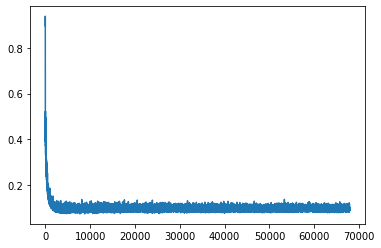

In [ ]:
import matplotlib.pyplot as plt

#name of the file where urbm model learned weights and biases will be saved.
save_weights_path = "/content/gdrive/My Drive/SpeakerVerification/SavedModels/urbm_model" 

data=augmented_dataset_mvn
lr  = 0.001
input_dim =80 # 80
hidden_dim = 400 # 200
batch_size = 100
nb_epoch = 100


gbrbm = GBRBM(n_visible=input_dim, n_hidden=hidden_dim, learning_rate=lr, momentum=0.95, use_tqdm=True)
errs = gbrbm.fit(data, n_epoches=nb_epoch, batch_size=batch_size)
gbrbm.save_weights(save_weights_path,'weights')
plt.plot(errs)
plt.show()

In [ ]:
gbrbm = GBRBM(n_visible=input_dim, n_hidden=hidden_dim, learning_rate=lr, momentum=0.95, use_tqdm=True)
print(gbrbm.get_weights())
gbrbm.load_weights(save_weights_path,'weights')
print(gbrbm.get_weights())
